In [6]:
import requests
from bs4 import BeautifulSoup
import http.client
from dotenv import load_dotenv
import json

import pandas as pd
import numpy as np
from datetime import datetime
import time
import ast  # To safely evaluate the string as a dictionary
import pycountry
import re

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from matplotlib.ticker import FixedLocator

import os

In [ ]:
# Construct City_country dataframe

# Create a mapping function for country abbreviations
def get_country_abbreviation(country_name):
    try:
         # use pycountry to get the country abbreviation
        country =  pycountry.countries.lookup(country_name)
        return country.alpha_2
    except LookupError:
         # If not found, return NaN
            # If not found, return NaN and print the country name
        #print(f"Country not found: {country_name}")
        return np.nan

# Get city_country dataframe
def city_country_dataframe():
    # load city, country dataframe
    city_country_df = pd.read_csv("worldcities.csv")

    # only select four colums:
    city_country_df = city_country_df[["city","lat","lng","country"]]

    # renmae column name
    city_country_df.rename(columns={"lng":"lon"},inplace=True)


    #apply(get_country_abbreviation) will pass each country name to the get_country_abbreviation function, which will return the 2-letter country code (if available).
    city_country_df["country_abbriev"] = city_country_df["country"].apply(get_country_abbreviation)
    # USA, UK
    city_country_df["country_abbriev"] = city_country_df["country_abbriev"].replace("US","USA") 
    city_country_df["country_abbriev"] = city_country_df["country_abbriev"].replace("GB","UK")      

    city_country_df.to_csv("city_country.csv")
    return city_country_df



# input city, country, then get location values
def input_city_country(city_country_df):
    # input city, country
    while True:
        while True:
            # Get valid city
            city = input("Please input the city: ").replace(" ","")
            if city.lower() not in city_country_df["city"].str.lower().to_list():
                print("City not found! Please input a valid city!")
            else:
                print(f"The valid city is: {city}!")
                break
      
    
        while True:
            # Get valid country
            country = input("Please input the country (or abbreviation): ").replace(" ","")
            country_match = (country.lower() in city_country_df["country"].str.lower().to_list()) or (country.upper() in city_country_df["country_abbriev"].str.upper().to_list())
            if not country_match:
                print("Country not found! Please input a valid country!")
            else:
                print(f"The valid country is: {country}!")
                break
 
    
        # Filter for the specific city and country
        fil_location = (
            (city_country_df["city"].str.lower()==city.lower()) & 
            (
                (city_country_df["country"].str.lower()==country.lower()) | 
                (city_country_df["country_abbriev"].str.upper()==country.upper())
            )
        )

        # Extract latitude and longitude as scalar values
        if not fil_location.any():  # Check if the city-country combination exists
            print(f"No data found for the location: {city}, {country}!")
        else:          
            break
        

    location_data = city_country_df.loc[fil_location].iloc[0]

    lat = location_data["lat"]  # Extract value
    lon = location_data["lon"]  # Extract value
    city = location_data["city"]
    country = location_data["country"]

    location = (city,country,lat,lon)
    
    print(F"The destination is: ({city}, {country}) --> Latitude and longitude: ({lat},{lon})")
    return location        
   


In [8]:
# hotel information via webscraping from booking.com

#-------------------------- Input period and numbers of room--------------------------------------
def input_check_room():
   
    current_date = datetime.now()
    formatted_date = f"{current_date:%Y-%m-%d}"

    # Get a valid check-in date
    while True:
        try:
            check_in_date = input("Please input the check-in date (YYYY-MM-DD): ")
            # used datetime.strptime to parse and validate check-in input
            check_in_date_obj = datetime.strptime(check_in_date,"%Y-%m-%d")
            # judge if check_in_date is latter than today
            # converted input strings to datetime objects for proper comparison
            if check_in_date_obj.date() < current_date.date():
                print("Check-in date cannot be earlier than today. Please try again")
            else:
                print(f"The check-in date is: {check_in_date_obj.date()}")
                break
        # judege if the check-in date is valid format or not
        except ValueError:
            print("Invalid date format. Please enter YYYY-MM-DD!")


    # Get a valid check-out date
    while True:
        try:
            check_out_date= input("Please input the check-out date (YYYY-MM-DD):")
            check_out_date_obj = datetime.strptime(check_out_date,"%Y-%m-%d")

            if (check_out_date_obj.date() <= check_in_date_obj.date()):
                print("Check-out date must be later than the check-in date! Please input check-out date again!")
            else:
                print(f"The check-out date is: {check_out_date_obj.date()}")
                break
        # judege if the check-in date is valid format or not
        except ValueError:
            print("Invalid date format. Please enter YYYY-MM-DD1")    

    
    # Get valid adult_num
    while True:
        try:
            adult_num = int(input("How many adults? "))
            if adult_num <= 0:
                print("Number of adults must be at least 1!")
            else:
                print(f"The number of adults is: {adult_num}")
                break
        # judege if the check-in date is valid format or not
        except ValueError:
            print("Invalid adult number. Please enter a positive integer1") 


    # Get valid room_num
    while True:
        try:
            room_num = int(input("How many rooms? "))
            if room_num <= 0:
                print("Number of rooms must be at least 1!")
            else:
                print(f"The number of room is: {room_num}")
                break
        # judege if the check-in date is valid format or not
        except ValueError:
            print("Invalid adult number. Please enter a positive integer!") 


    # Get valid children_num
    while True:
        try:
            children_num = int(input("How many chilrdern? "))
            if children_num < 0:
                print("Number of children cannot be negative!")
            else:
                print(f"The number of children is: {children_num}")
                break
                # judege if the check-in date is valid format or not
        except ValueError:
            print("Invalid children number. Please enter a non-negative integer!") 


    period = (check_in_date,check_out_date)
    num = (adult_num,room_num,children_num)

    return period,num




# ---------------------------------now start to change the variable in url----------------------------

def get_hotel_url(location,period,num):
    # room location
    city = location[0]
    country = location[1]
    
    # room time
    check_in_date = period[0]
    check_out_date = period[1]
 
    # room num
    adult_num = num[0]
    romm_num = num[1]
    children_num = num[2]

    hotel_url = f"https://www.booking.com/searchresults.en-gb.html?ss={city}%2C+Community+of+{city}%2C+{country}&efdco=1&label=gen173bo-1DCAEoggI46AdICVgDaMgBiAEBmAEJuAEXyAEM2AED6AEB-AEDiAIBmAICqAIDuAKNxYG6BsACAdICJDc4YzI3MmQ4LWM1NzMtNDE4MS04MTk0LTZlMTdkZWNjMWQwZdgCBOACAQ&sid=badcbe9c6b390c4f5668ded61093febe&aid=304142&lang=en-gb&sb=1&src_elem=sb&src=index&dest_id=-390625&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=d4b24c866c100605&ac_meta=GhBkNGIyNGM4NjZjMTAwNjA1IAAoATICZW46BE1hZHJAAEoAUAA%3D&checkin={check_in_date}&checkout={check_out_date}&group_adults={adult_num}&no_rooms={romm_num}&group_children={children_num}&order=price"

    return hotel_url


def get_container(url,headers):
    # request to the website
    response = requests.get(url,headers=headers)
    html= response.content
    soup = BeautifulSoup(html)

    # choose container
    hotel_container = soup.select("div > div.c624d7469d.a0e60936ad.a3214e5942.b0db0e8ada")

    container = []

    # filter out ad
    for con in hotel_container:
        # Check for ad markers
        if con.find("span", class_="b30f8eb2d6", string="Ad"):
            print("Ad found, skipping...")
            continue
        container.append(con)

    return container



#-------------------------------loop container to extract hote name, price, rating, vote---------------------------

# extract hote data
def selector_extract(item, selector):
    parse = item.select(selector)
    if parse:
        return parse[0].text
    else:
        return np.nan
    

def get_selector():
    selector = []
    
    name_selector = "a > div.f6431b446c.a15b38c233"
    selector.append(name_selector)

    price_selector = "div > span.f6431b446c.fbfd7c1165.e84eb96b1f"
    selector.append(price_selector)

    rating_selector = "div > div.ac4a7896c7"
    selector.append(rating_selector)

    vote_selector = "div > div.abf093bdfe.f45d8e4c32.d935416c47"
    selector.append(vote_selector)

    distance_selector = 'span > span[data-testid="distance"]'
    selector.append(distance_selector)

    return selector


def extract_hotel_web(container,selector,location):
    # selector 
    name_selector =  selector[0]
    price_selector =  selector[1]
    rating_selector =  selector[2]
    vote_selector =  selector[3]
    distance_selector =  selector[4]
   
    name_lst =[]
    price_lst = []
    rating_lst = []
    vote_lst = []
    distance_lst = []

    #loop container
    for con in container:
        #name
        name = selector_extract(con, name_selector)
        name_lst.append(name)

        #price
        price = selector_extract(con, price_selector)
        price_lst.append(price)


        #rating
        rating = selector_extract(con, rating_selector)
        vote = selector_extract(con, vote_selector)
        if (not "Scored" in rating) and (con.find("span", class_="b30f8eb2d6", string="New to Booking.com")):
            rating = np.nan
            vote = np.nan
        rating_lst.append(rating)
        vote_lst.append(vote)

        #distance
        distance = selector_extract(con, distance_selector)
        distance_lst.append(distance)

#    print(name_lst)
#    print(price_lst)
#    print(rating_lst)
#    print(vote_lst)
#    print(distance_lst)

    dic_hotel = {}

    city = location[0]
    country = location[1]

    dic_hotel = {"city":city,"country":country,"name":name_lst,"price":price_lst,"rating":rating_lst,"vote":vote_lst,"distance":distance_lst}

    return dic_hotel

In [9]:
# Weather information via connecting to API


# ------------------Load env information----------------------------
load_dotenv(dotenv_path=r"C:\Users\taoti\GitHub\Hotel_Recommendations\.env")

print(os.environ["weather_api_host"])
print(os.environ["weather_api_key"])

def get_weather_url(location):
    city = location[0]
    country = location[1]
    lat = location[2]
    lon = location[3]
    # get url variable
    weather_url = f"/forecast/daily?lat={lat}&lon={lon}&units=metric&lang=en"
    return weather_url 


# define function to extract data from API given url, conn
def extract_weather_API(city,url,conn,headers):
    try: 
        # Request to the API, and get data as the response
        conn.request("GET", url, headers=headers)
        res = conn.getresponse()
        data = res.read()

        # Parse JSON and extract data
        weather_data = json.loads(data)
        #print(f"Response for {city}: {weather_data}")
        
        if 'data' in weather_data:
                records = weather_data['data']
                # Add city information to each record
                for record in records:
                    record['city'] = city
                all_weather_data.extend(records)
        else:
                print(f"No 'data' key found for {city}. Skipping...")
                time.sleep(1)  # Wait 1 second between requests
    except Exception as e:
        print(f"Error fetching data for {city}: {e}")
        time.sleep(5)  # Wait 5 seconds before retrying
    
    return all_weather_data



weatherbit-v1-mashape.p.rapidapi.com
a29fa7550emshd22ad2dcdc1d6fap1bfd73jsnbc24356674f8


The valid city is: Madrid!
The valid city is: Spain!
The destination is: (Madrid, Spain) --> Latitude and longitude: (40.4169,-3.7033)
The check-in date is: 2024-11-25
The check-out date is: 2024-12-12
The number of adults is: 1
The number of room is: 1
The number of children is: 0


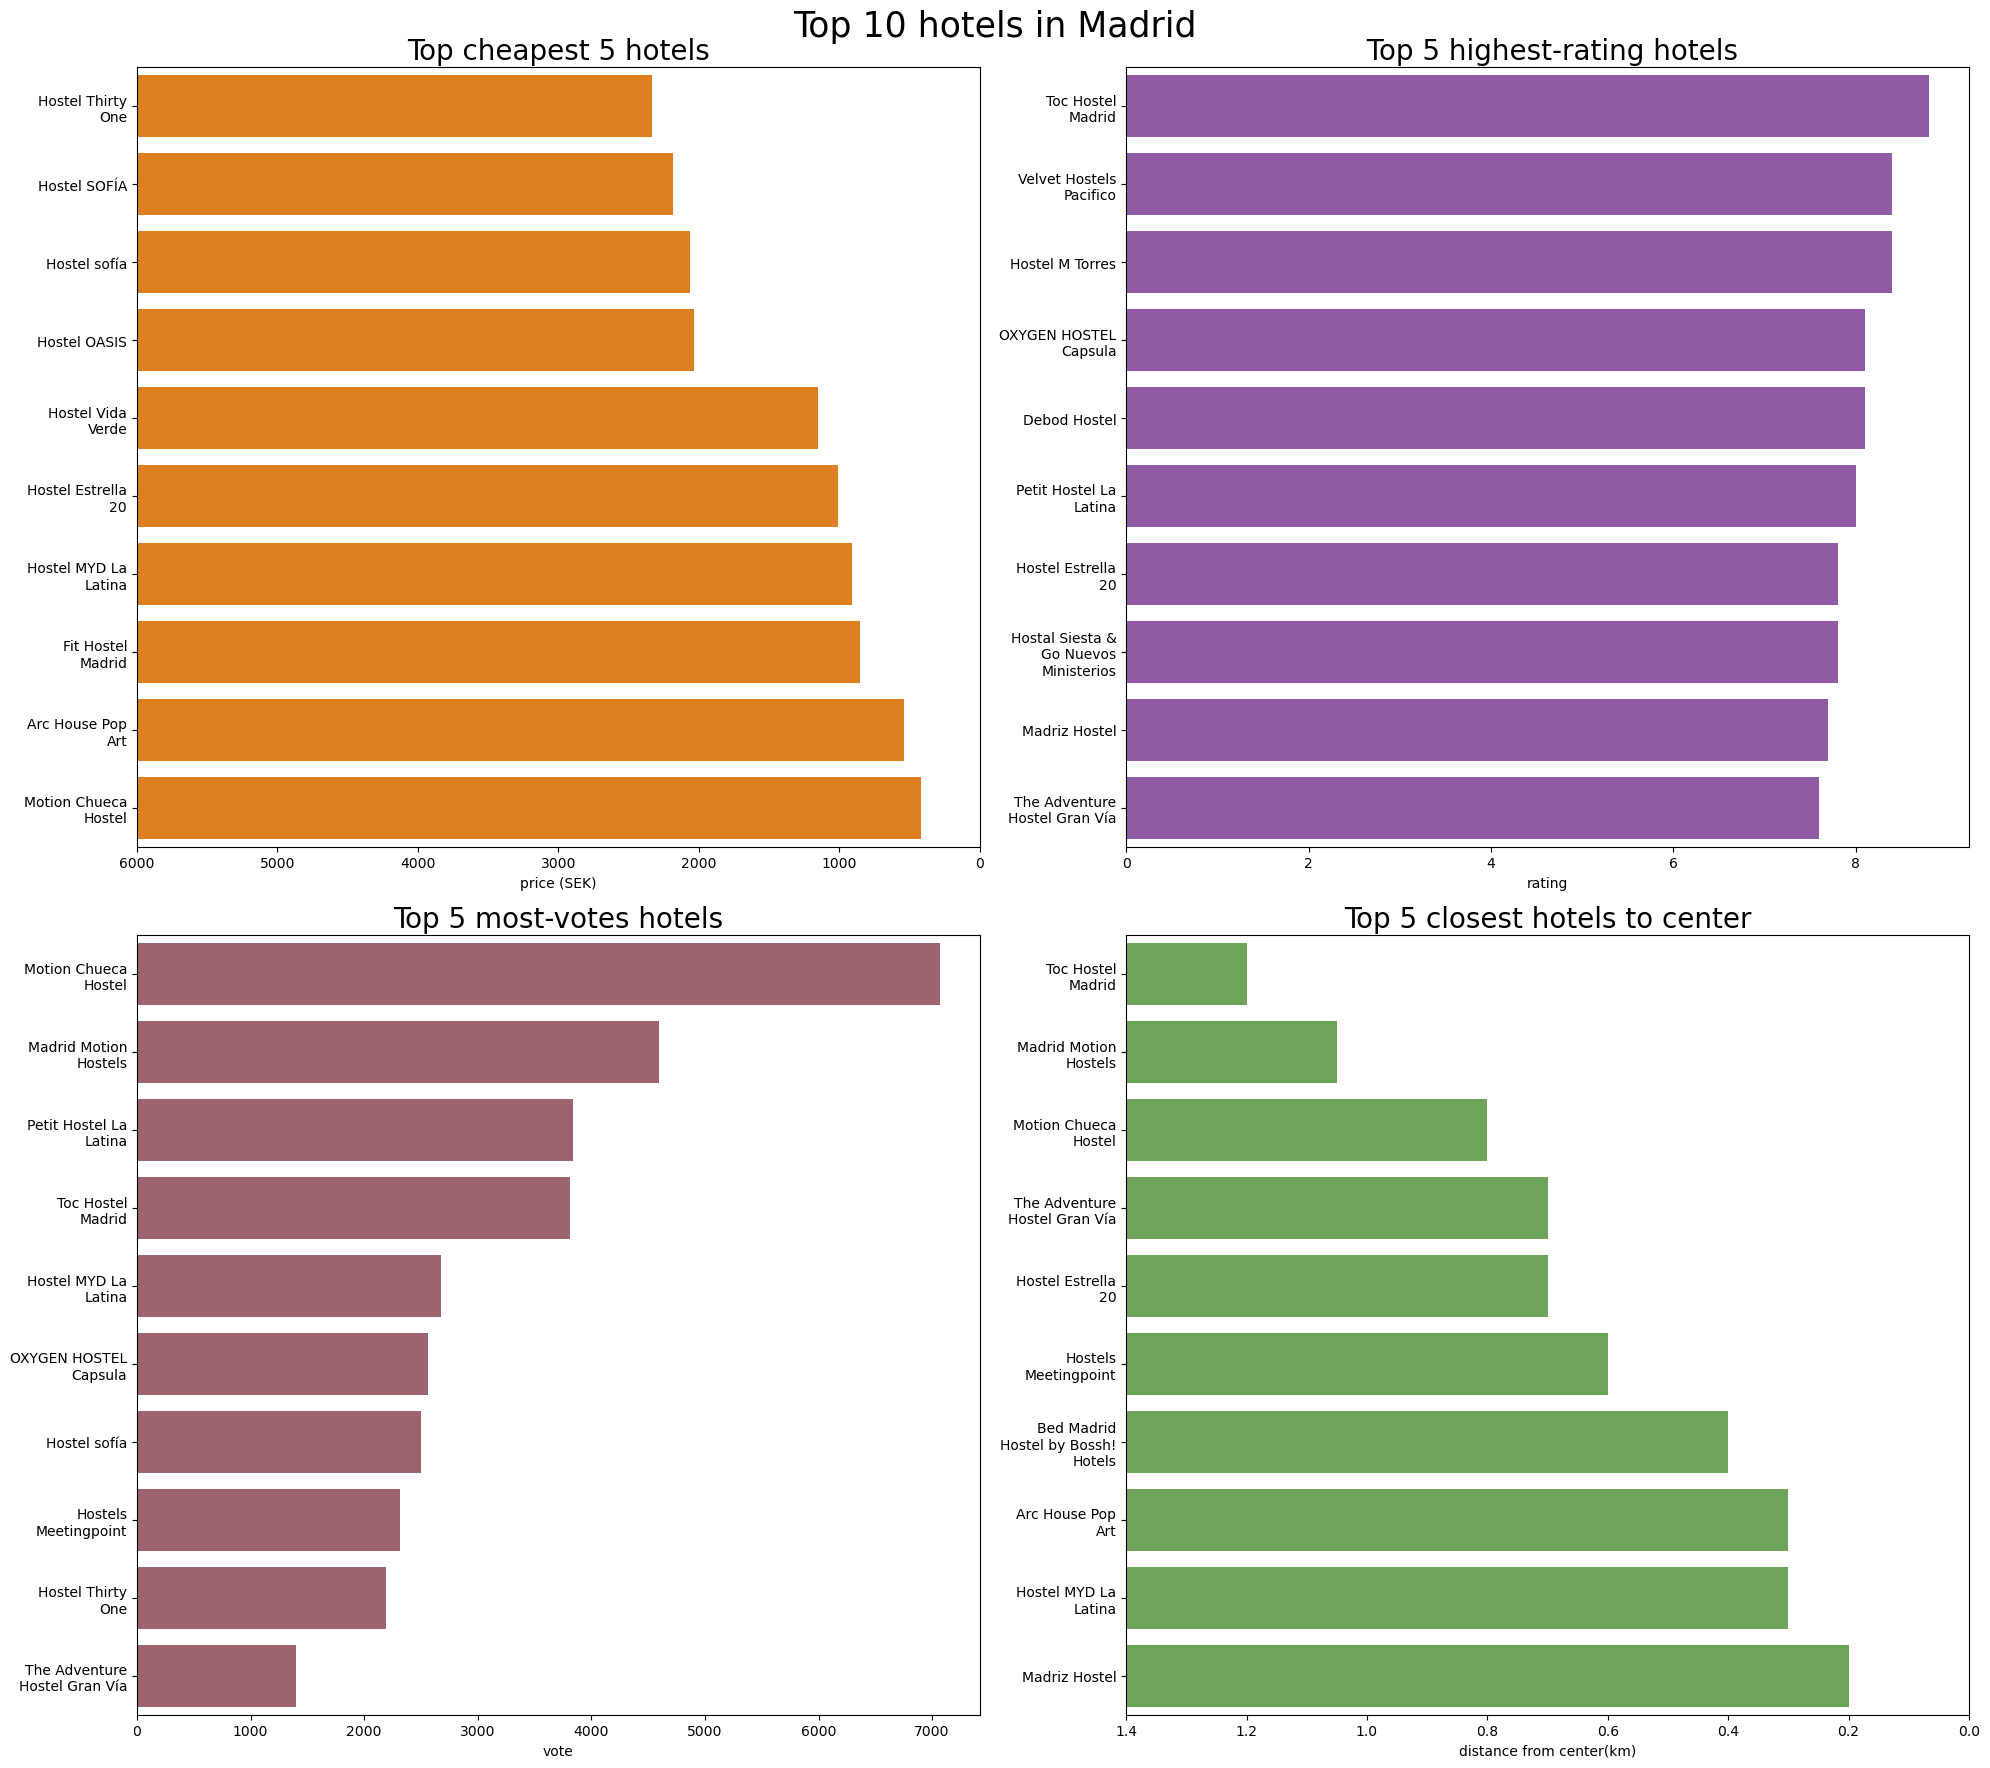

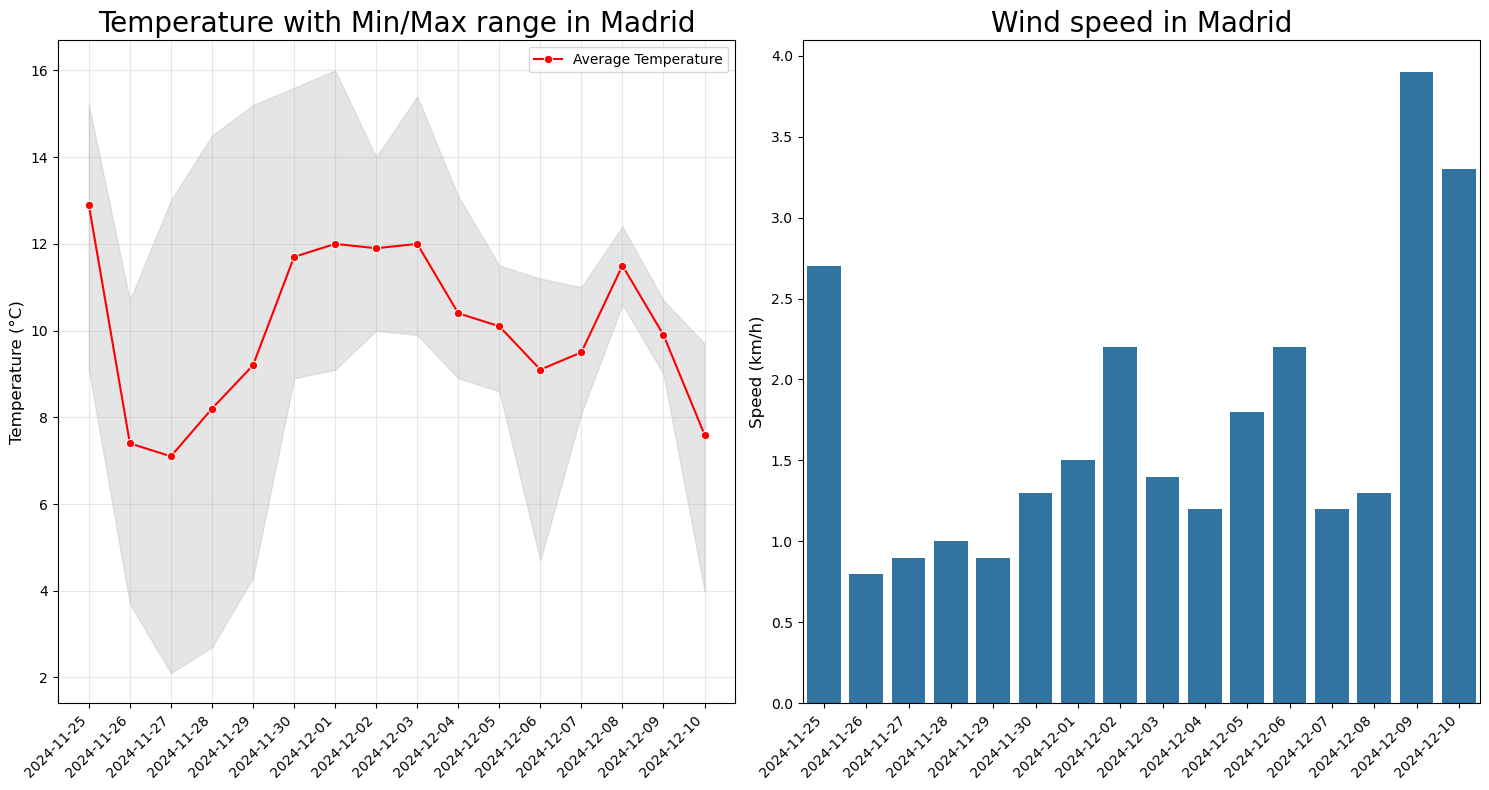

In [13]:
# Main functon:


#-------------------------------------------Hotel data via webscraping-------------------------------------------------------
hotel_headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

selector = []
selector = get_selector()

# load city, country dataframe

# get city_country_df
city_country_df = city_country_dataframe()
# input city, country
location = input_city_country(city_country_df)
period,num = input_check_room()
hotel_url = get_hotel_url(location,period,num)
#print(f"The url of booking website is: {hotel_url}\n")

container = get_container(hotel_url,hotel_headers)
dic_hotel = extract_hotel_web(container,selector,location)

hotel_df = pd.DataFrame()
hotel_df = pd.DataFrame(dic_hotel)
hotel_df.dropna(inplace=True)
# Save the DataFrame to a CSV file
hotel_df.to_csv("hotel_data_country.csv", index=False)



# -----------------Weather data via API-------------------
# Initialize connection
conn = http.client.HTTPSConnection(os.environ["weather_api_host"])
weather_headers = {
    'x-rapidapi-key': os.environ["weather_api_key"],
    'x-rapidapi-host': os.environ["weather_api_host"]
}

# get url 
weather_url = get_weather_url(location)

# Create a list all_weather_data to store all records
all_weather_data = []
all_weather_data = extract_weather_API(location[0],weather_url,conn,weather_headers)

# store data requested from API into dataframe for the convinience of analysis
# Create DataFrame from lsit all_weather_data
weather_df = pd.DataFrame()
weather_df = pd.DataFrame(all_weather_data)
# Save the DataFrame to a CSV file
weather_df.to_csv("weather_data_country.csv", index=False)



# --------------------------------------Visualize hotel data------------------------------------------------

#hotel_df = pd.read_csv("hotel_data_country.csv")

# in column "rating": value "Scored 5.9" delete "Scored", change the str type to float type
# in column "vote": value "321 reviews" delete "reviews", change the str type to int
# in column "distance": change column name "distance" to "distance from center(km)", change delete "km from centre", change the str type to float type
# in column "price": price 

hotel_df["rating"] = hotel_df["rating"].apply(lambda x: float(x.split(" ")[1]))
hotel_df["vote"] = hotel_df["vote"].apply(lambda x: int(x.split(" ")[0].replace(",","")))
hotel_df["distance"] = hotel_df["distance"].apply(lambda x: float(x.split(" ")[0]) if x.split(" ")[1]=='km' 
                                      else float(x.split(" ")[0])/1000 if x.split(" ")[1]=='m'
                                      else None)
hotel_df.rename(columns={"distance":"distance from center(km)"},inplace=True)

hotel_df["price"] = hotel_df["price"].apply(lambda x: float(x.split("\xa0")[1].replace(",","")))
hotel_df.rename(columns={"price":"price (SEK)"},inplace=True)


# set color
primary_colors = [ "#D83227","#42baa4","#974DB2","#f8ee07","#f90655","#184fe7"]   
secondary_colors = ["#68B24D","#fd7f02","#3e73ba","#d15b9f","#a45b68"]
contrast_colors=["#13d5ec"]

tian_colors = primary_colors + secondary_colors + contrast_colors


# draw a figure
fig,ax_hot = plt.subplots(2,2,figsize=(20,18))

# Top 10 chepest hotels:
hotel_top_10_cheap = hotel_df.sort_values(by="price (SEK)",ascending=True).iloc[:10]
city = hotel_top_10_cheap.loc[0,"city"]
sns.barplot(data=hotel_top_10_cheap,x="price (SEK)",y="name",orient="h",errorbar=None,color=secondary_colors[1],ax=ax_hot[0,0])
ax_hot[0,0].set_title("Top cheapest 5 hotels",fontsize=20)
ax_hot[0,0].set_ylabel("",fontsize=12)

# Get the current x-tick positions
x_ticks = ax_hot[0, 0].get_xticks()
# Reverse the x-tick positions (this keeps the plot direction the same)
reversed_ticks = x_ticks[::-1]
ax_hot[0, 0].set_xticks(reversed_ticks)
# Get current x-tick labels and reverse them
# get_xticklabels() gives you the actual label objects, 
# so we use get_text() to extract the text (i.e., the labels) from those objects, and then reverse them
x_labels = [label.get_text() for label in ax_hot[0, 0].get_xticklabels()]
ax_hot[0, 0].set_xticklabels(x_labels[::-1])  # Set the reversed labels

# wrap the y-tick lables to 2 lines
lables = ax_hot[0,0].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# Fix y-tick positions with FixedLocator
ax_hot[0, 0].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[0, 0].set_yticklabels(wrapped_labels)

# Top 10 highest-rating hotels:
hotel_top_10_cheap = hotel_df.sort_values(by="rating",ascending=False).iloc[:10]
sns.barplot(data=hotel_top_10_cheap,x="rating",y="name",orient="h",errorbar=None,color=primary_colors[2],ax=ax_hot[0,1])
ax_hot[0,1].set_title(" Top 5 highest-rating hotels",fontsize=20)
ax_hot[0,1].set_ylabel("",fontsize=12)
# wrap the y-tick lables to 2 lines
lables = ax_hot[0,1].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# set_yticklabels(): After wrapping the labels, we set them back to the x-axis with rotation for better readability.
ax_hot[0, 1].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[0, 1].set_yticklabels(wrapped_labels)

# Top 10 most-votes hotels:
hotel_top_10_cheap = hotel_df.sort_values(by="vote",ascending=False).iloc[:10]
sns.barplot(data=hotel_top_10_cheap,x="vote",y="name",orient="h",errorbar=None,color=secondary_colors[4],ax=ax_hot[1,0])
ax_hot[1,0].set_title("Top 5 most-votes hotels",fontsize=20)
ax_hot[1,0].set_ylabel("",fontsize=12)
# wrap the x-tick lables to 2 lines
lables = ax_hot[1,0].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# set_xticklabels(): After wrapping the labels, we set them back to the x-axis with rotation for better readability.
ax_hot[1, 0].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[1, 0].set_yticklabels(wrapped_labels)

# Top 10 closest hotels to center:
hotel_top_10_cheap = hotel_df.sort_values(by="distance from center(km)",ascending=True).iloc[:10]
sns.barplot(data=hotel_top_10_cheap,x="distance from center(km)",y="name",orient="h",errorbar=None,color=secondary_colors[0],ax=ax_hot[1,1])
ax_hot[1,1].set_title("Top 5 closest hotels to center",fontsize=20)
ax_hot[1,1].set_ylabel("",fontsize=12)

# Get the current y-tick positions
x_ticks = ax_hot[1, 1].get_xticks()
# Reverse the y-tick positions (this keeps the plot direction the same)
reversed_ticks = x_ticks[::-1]
ax_hot[1, 1].set_xticks(reversed_ticks)
# Get current y-tick labels and reverse them
# get_yticklabels() gives you the actual label objects, 
# so we use get_text() to extract the text (i.e., the labels) from those objects, and then reverse them
x_labels = [label.get_text() for label in ax_hot[1, 1].get_xticklabels()]
ax_hot[1, 1].set_xticklabels(x_labels[::-1])  # Set the reversed labels

# wrap the y-tick lables to 2 lines
lables = ax_hot[1,1].get_yticklabels()
# textwrap.fill(): This function breaks long strings into multiple lines.
# You can adjust the 10 in textwrap.fill(label.get_text(), 10) to set the maximum number of characters per line.
wrapped_labels = [textwrap.fill(label.get_text(),16) for label in lables]
# set_yticklabels(): After wrapping the labels, we set them back to the x-axis with rotation for better readability.
ax_hot[1, 1].yaxis.set_major_locator(FixedLocator(range(len(wrapped_labels))))
ax_hot[1, 1].set_yticklabels(wrapped_labels)

plt.suptitle(f"Top 10 hotels in {city}",fontsize=25)
plt.tight_layout()
plt.savefig("hotel_recommendation.png", transparent = False, bbox_inches="tight")
plt.show()



#-------------------------------------Visualize weather data-------------------------------------------------------
# 1. only select three columns: city, date, temp, weather; 
# 2. replace the columns "{'code': 801, 'icon': 'c02n', 'description': 'Few clouds'}" with {'Few clouds'};
# 3. deal with datetime: only select day rows groubpy city;

weather_df = weather_df[["city","datetime", "weather", "temp","app_max_temp","app_min_temp","snow_depth","wind_spd"]]
# Convert the 'weather' column from string to dictionary because now the 'weather' column is not dictionary but string.
# The apply method is used to apply a function to each element in the column;
# df_1(lambda x: x["weather"] = dic['description'] for dic in x["weather"]) 
weather_df["weather"] = weather_df["weather"].apply(lambda x: x['description'])    

# filter out the weather during the input period
# filter the datafrmae for date between check_in_date and check_out_date
check_in_date = period[0]
check_out_date = period[1]

filter_weather_df = weather_df[(weather_df["datetime"] >= check_in_date) & (weather_df["datetime"] <= check_out_date)]


# plot the weather over days

fig,ax_wea= plt.subplots(1,2,figsize=(15,8))

# temperature
sns.lineplot(data=filter_weather_df,x="datetime",y="temp",label="Average Temperature",color="red",marker="o",ax=ax_wea[0])
ax_wea[0].fill_between(filter_weather_df["datetime"],filter_weather_df["app_min_temp"],filter_weather_df["app_max_temp"],color="#BFBFBF", alpha=0.4)
ax_wea[0].set_title(f'Temperature with Min/Max range in {city}', fontsize=20)
ax_wea[0].set_xlabel('',fontsize=12)
ax_wea[0].set_ylabel('Temperature (°C)',fontsize=12)
ax_wea[0].tick_params(axis="x",rotation=45)
# Set ha="right" for x-axis tick labels
for label in ax_wea[0].get_xticklabels():
    label.set_horizontalalignment('right')
ax_wea[0].legend()
ax_wea[0].grid(True, alpha=0.3)


# wind speed
sns.barplot(data=filter_weather_df,x="datetime",y="wind_spd",ax=ax_wea[1])
ax_wea[1].set_title(f'Wind speed in {city}', fontsize=20)
ax_wea[1].set_xlabel('',fontsize=12)
ax_wea[1].set_ylabel('Speed (km/h)',fontsize=12)
ax_wea[1].tick_params(axis="x",rotation=45)
# Set ha="right" for x-axis tick labels
for label in ax_wea[1].get_xticklabels():
    label.set_horizontalalignment('right')
#ax_wea[1].legend()

plt.tight_layout()
plt.savefig("weather_forcast", transparent = False, bbox_inches="tight")
plt.show()
